# Ground Projection

In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rc("figure", dpi=200)

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6
from dt_computer_vision.ground_projection.rendering import debug_image
from dt_computer_vision_tests.line_detection_tests.test_detection import detect_color
from dt_computer_vision.ground_projection import GroundProjector

from dt_computer_vision.ground_projection.types import GroundPoint
from dt_computer_vision.camera import Pixel, NormalizedImagePoint

In [4]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image0.jpg")
image_orig: np.ndarray = cv2.imread(image_fpath)
assert image_orig.shape == (480, 640, 3)

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}


# create camera
camera = CameraModel(**camera_properties)

## Ground Projection and Resolution Independent Homographies

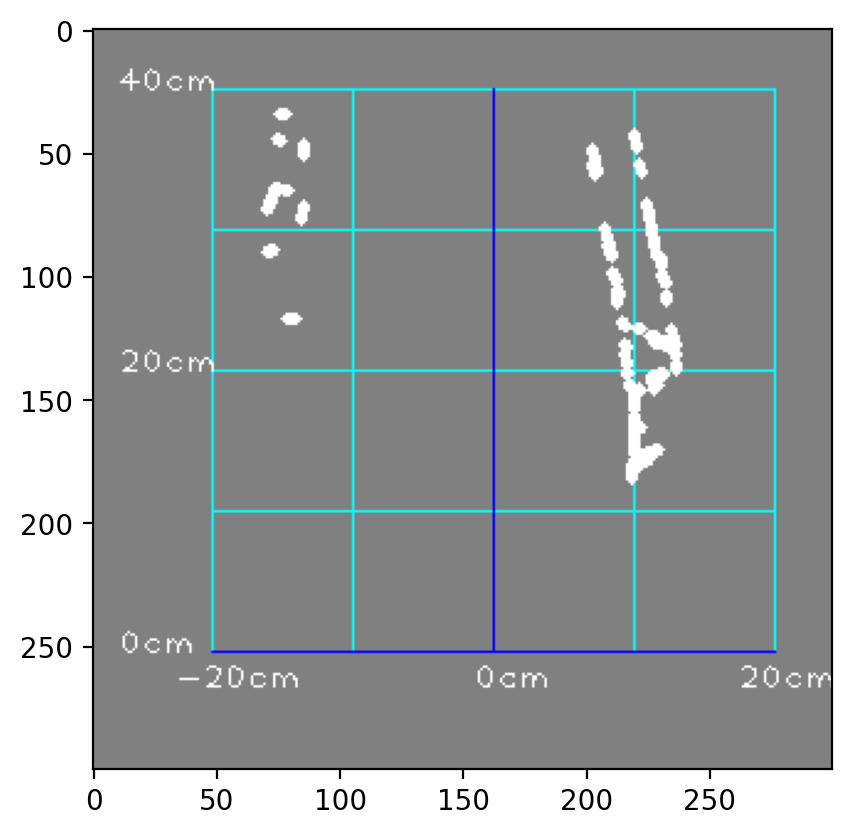

In [5]:
from dt_computer_vision.camera.homography import ResolutionDependentHomography, ResolutionIndependentHomography

# define cropping
crop_y_amount = 0
crop_y = int(image_orig.shape[0] * crop_y_amount)

# crop image
image_cropped = image_orig[crop_y:, :, :]

# create new camera (shortcut compared to cells above)
camera_cropped: CameraModel = camera.cropped(top=crop_y)

# detect segments
color: str = "white"
segments_cropped, image_w_detections_cropped = detect_color(image_cropped, color)


# old (~2016, pontiac) resolution-independent homography
H_ri = np.array([
    -4.89775e-05,
    -0.0002150858,
    -0.1818273,
    0.00099274,
    1.202336e-06,
    -0.3280241,
    -0.0004281805,
    -0.007185673,
    1]).reshape((3,3))

# test homography on detected segments
def test_homography(_H: np.ndarray, _ri: bool):
    colored_segments_cropped = {
        (255, 255, 255): []
    }
    
    #camera_cropped.H = _H
    #projector_cropped: GroundProjector = GroundProjector(camera_cropped)
    
    for segment in segments_cropped.lines:
        # distorted pixels
        p0: Pixel = Pixel(segment[0], segment[1])
        p1: Pixel = Pixel(segment[2], segment[3])
        #print(p0)
        # distorted pixels to rectified pixels
        p0_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p0)
        p1_rect: Pixel = camera_cropped.rectifier.rectify_pixel(p1)
        #print(p0_rect)
        # rectified pixel to normalized coordinates
        p0_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p0_rect)
        p1_norm: NormalizedImagePoint = camera_cropped.pixel2vector(p1_rect)
        #print(p0_norm)
        # project image point onto the ground plane
        # p0_ground: GroundPoint = projector_cropped.vector2ground(p0_norm)
        # p1_ground: GroundPoint = projector_cropped.vector2ground(p1_norm)

        if _ri:
            # use resolution-independent image normalization
            # p0_ground_arr: np.ndarray = np.dot(_H, [p0.x / camera_cropped.width, p0.y / camera_cropped.height, 1])
            # p1_ground_arr: np.ndarray = np.dot(_H, [p1.x / camera_cropped.width, p1.y / camera_cropped.height, 1])
            
            p0_ground_arr: np.ndarray = np.dot(_H, [p0.x, p0.y, 1])
            p1_ground_arr: np.ndarray = np.dot(_H, [p1.x, p1.y, 1])
        else:
            # use conventional image normalization
            p0_ground_arr: np.ndarray = np.dot(_H, [p0_norm.x, p0_norm.y, 1])
            p1_ground_arr: np.ndarray = np.dot(_H, [p1_norm.x, p1_norm.y, 1])

        p0_ground_arr = p0_ground_arr[:2] / p0_ground_arr[2]
        p1_ground_arr = p1_ground_arr[:2] / p1_ground_arr[2]
        
        p0_ground: GroundPoint = GroundPoint(p0_ground_arr[0], p0_ground_arr[1])
        p1_ground: GroundPoint = GroundPoint(p1_ground_arr[0], p1_ground_arr[1])


        # print((p0, p1), "->", (p0_ground, p1_ground))


        
        # print(p0)
        # add grounded segment to output
        colored_segments_cropped[(255, 255, 255)].append((p0_ground, p1_ground))
    
    image_w_projected_segments_cropped = debug_image(colored_segments_cropped, (300, 300))
    image_w_projected_segments_cropped = cv2.cvtColor(image_w_projected_segments_cropped, cv2.COLOR_BGR2RGB)
    plt.imshow(image_w_projected_segments_cropped)


# test with given homography, this should just work
#test_homography(camera_cropped.H, _ri=False)


# resolution-independent homography
Hi2x: ResolutionIndependentHomography = ResolutionIndependentHomography.read(H_ri)

test_homography(H_ri, _ri=True)


# resolution-dependent homography
#Hv2x: ResolutionDependentHomography = ResolutionDependentHomography.read(H)


#test_homography(Hv2x)

# resolution-independent homography
#Hi2x: ResolutionIndependentHomography = Hv2x.camera_independent(camera)

# back to resolution-dependent homography
#Hv2x_: ResolutionDependentHomography = Hi2x.camera_specific(camera)

# compare
#print(Hv2x.round(8).tolist())
#print(Hi2x.round(8).tolist())
#print(Hv2x_.round(8).tolist())

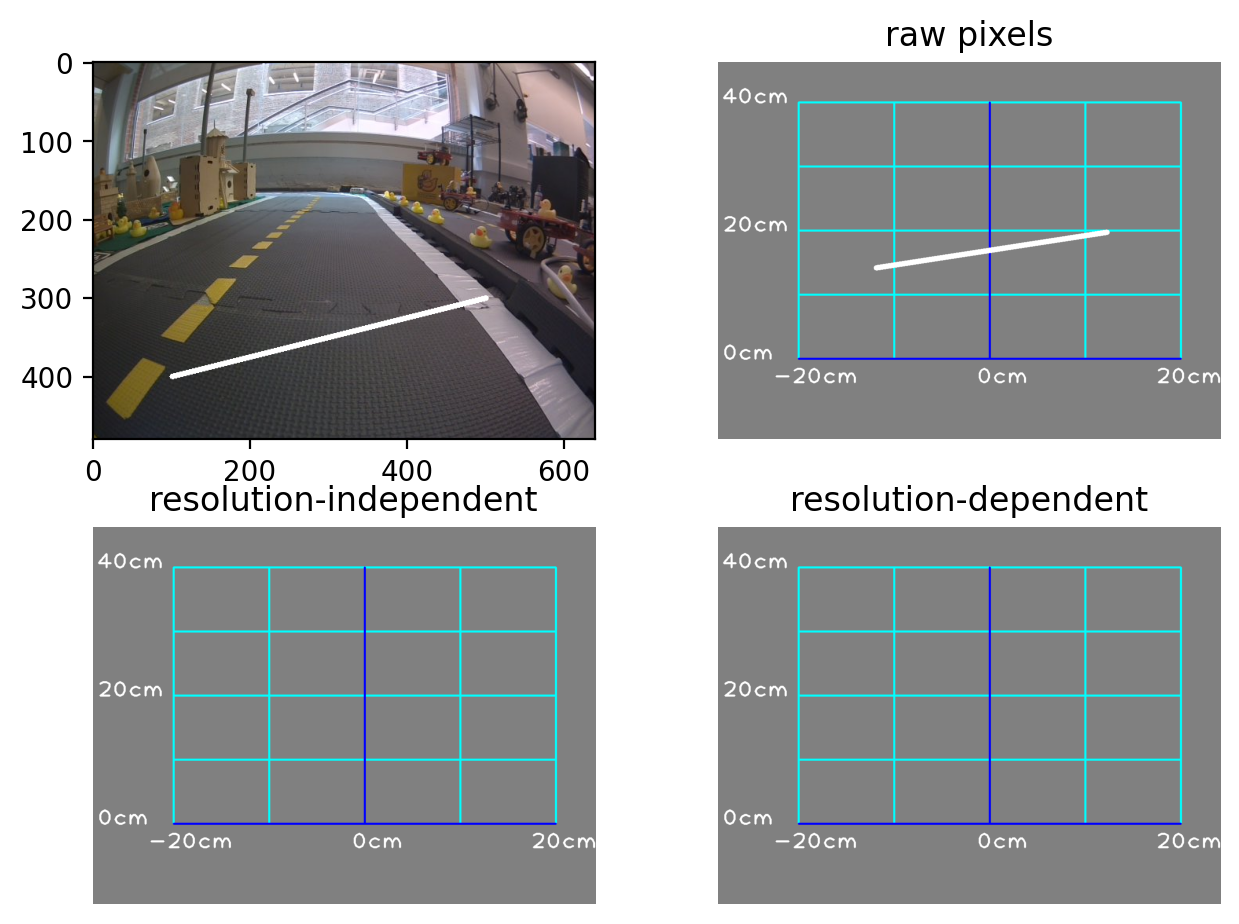

In [6]:
from copy import deepcopy

image = deepcopy(image_orig)

white = (255, 255, 255)

# single segment
p0 = Pixel(100, 400)
p1 = Pixel(500, 300)

# draw segments
image_with_segment = cv2.line(image, (p0.x, p0.y), (p1.x, p1.y), color=white, thickness=5)
image_with_segment = cv2.cvtColor(image_with_segment, cv2.COLOR_BGR2RGB)

# old (~2015, pontiac) camera matrix K and resolution-independent homography H
K = np.array([
    [307.73,      0, 329.69],
    [0,      314.98, 244.46],
    [0,           0,      1]
])
H = np.array([
            [ 0.45484525,  0.33783685,  0.11218921],
            [-0.02801287,  1.02463437, -0.07835274],
            [-0.19216963,  3.63163831,  1.        ]
])

fig, axis = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()

def test_H(ax, title, x0, y0, x1, y1):
    g0 = np.dot(H, [x0, y0, 1])
    g1 = np.dot(H, [x1, y1, 1])
    g0 = g0[:2] / g0[2]
    g1 = g1[:2] / g1[2]

    ground0 = GroundPoint(g0[0], g0[1])
    ground1 = GroundPoint(g1[0], g1[1])

    image_with_projected_segment = debug_image({white: [(ground0, ground1)]}, (1200, 900))
    image_with_projected_segment = cv2.cvtColor(image_with_projected_segment, cv2.COLOR_BGR2RGB)
    ax.imshow(image_with_projected_segment)
    ax.set_title(title)
    ax.set_axis_off()


axis[0][0].imshow(image_with_segment)

# using raw pixels
test_H(axis[0][1], "raw pixels", p0.x, p0.y, p1.x, p1.y)

# using resolution-independent points
test_H(axis[1][0], "resolution-independent", p0.x / 640, p0.y / 480, p1.x / 640, p1.y / 480)

# using resolution-dependent points
cx, cy, fx, fy = K[0][2], K[1][2], K[0][0], K[1][1]
test_H(axis[1][1], "resolution-dependent", (p0.x - cx) / fx, (p0.y - cy) / fy, (p1.x - cx) / fx, (p1.y - cy) / fy)

plt.show()

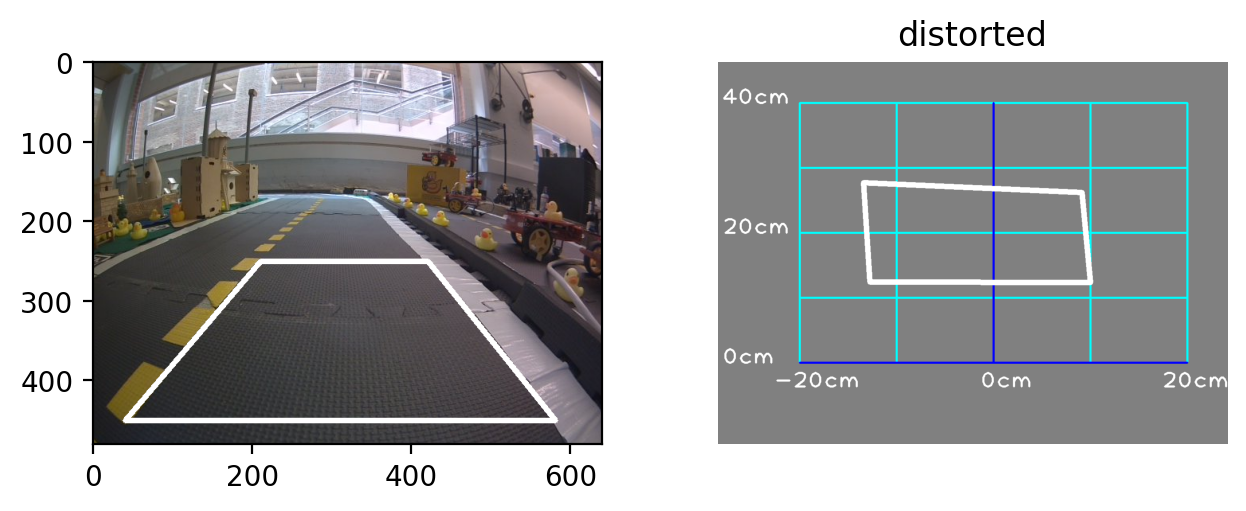

In [7]:
from copy import deepcopy

image = deepcopy(image_orig)
white = (255, 255, 255)

# old (~2015, pontiac) camera matrix K and resolution-independent homography H
K = np.array([
    [295.79606866959824, 0.0, 321.2621599038631],
    [0.0, 299.5389048862878, 241.73616515312332],
    [0.0, 0.0, 1.0]
])
H = np.array([
    [-4.89775e-05,  -0.0002150858, -0.1818273],
    [0.00099274,     1.202336e-06, -0.3280241],
    [-0.0004281805,  -0.007185673,          1]
])
D = np.array([
    -0.23543978771661125,
    0.03637781479419574,
    -0.0033069818601306755,
    -0.0012140708179525926,
    0.0
])



# corners
a, b, c, d = Pixel(40, 450), Pixel(580, 450), Pixel(420, 250), Pixel(210, 250)

# segments
segments = [
    (a, b), (b, c), (c, d), (d, a)
]

# draw segments
for p0, p1 in segments:
    image_with_segments = cv2.line(image, (p0.x, p0.y), (p1.x, p1.y), color=white, thickness=5)
image_with_segments = cv2.cvtColor(image_with_segments, cv2.COLOR_BGR2RGB)


fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()

ax0.imshow(image_with_segments)

projected_segments = []

for p0, p1 in segments:
    g0 = np.dot(H, [p0.x, p0.y, 1])
    g1 = np.dot(H, [p1.x, p1.y, 1])
    g0 = g0[:2] / g0[2]
    g1 = g1[:2] / g1[2]

    ground0 = GroundPoint(g0[0], g0[1])
    ground1 = GroundPoint(g1[0], g1[1])

    projected_segments.append((ground0, ground1))

image_with_projected_segments = debug_image({white: projected_segments}, (1200, 900))
image_with_projected_segments = cv2.cvtColor(image_with_projected_segments, cv2.COLOR_BGR2RGB)
ax1.imshow(image_with_projected_segments)
ax1.set_title("distorted")
ax1.set_axis_off()

plt.show()

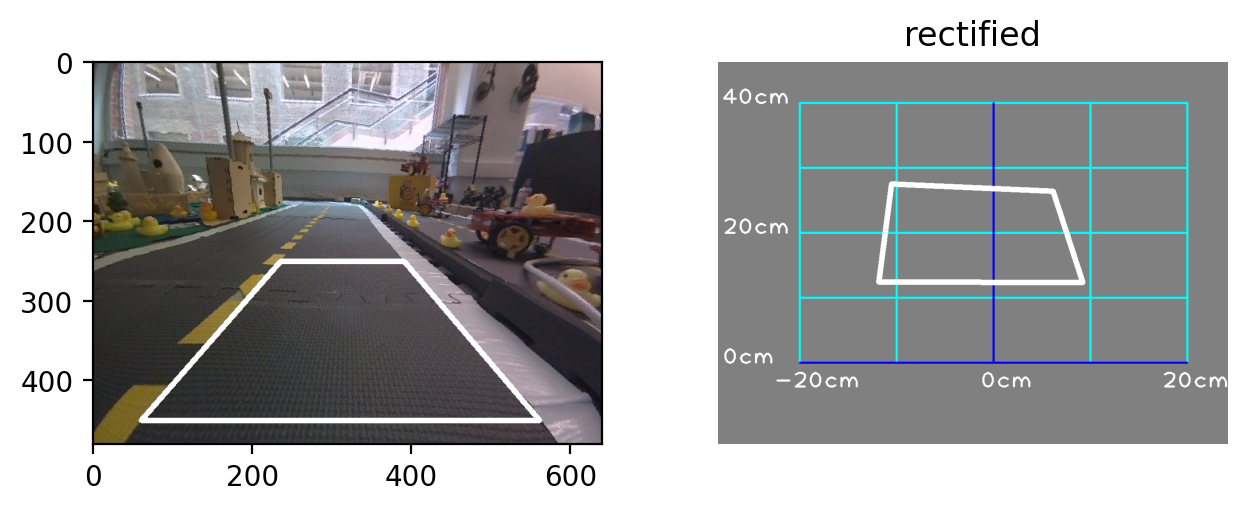

In [8]:
from copy import deepcopy

from dt_computer_vision.camera.types import Rectifier


image = deepcopy(image_orig)
white = (255, 255, 255)

K = np.array([
    [295.79606866959824, 0.0, 321.2621599038631],
    [0.0, 299.5389048862878, 241.73616515312332],
    [0.0, 0.0, 1.0]
])
D = np.array([
    -0.23543978771661125,
    0.03637781479419574,
    -0.0033069818601306755,
    -0.0012140708179525926,
    0.0
])
P = np.array([
    [201.14027404785156, 0.0, 319.5586620845679, 0.0],
    [0.0, 239.74398803710938, 237.60151004037834, 0.0],
    [0.0, 0.0, 1.0, 0.0]
])

camera = CameraModel(
    width=640,
    height=480,
    K=K,
    D=D,
    P=P
)
rectifier = Rectifier(camera)


# old (~2015, pontiac) homography H
H = np.array([
    [-4.89775e-05,  -0.0002150858, -0.1818273],
    [0.00099274,     1.202336e-06, -0.3280241],
    [-0.0004281805,  -0.007185673,          1]
])

image = rectifier.rectify(image)

# corners
a, b, c, d = Pixel(60, 450), Pixel(560, 450), Pixel(390, 250), Pixel(235, 250)

# segments
segments = [
    (a, b), (b, c), (c, d), (d, a)
]

# draw segments
for p0, p1 in segments:
    image_with_segments = cv2.line(image, (p0.x, p0.y), (p1.x, p1.y), color=white, thickness=5)
image_with_segments = cv2.cvtColor(image_with_segments, cv2.COLOR_BGR2RGB)


fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
fig.tight_layout()

ax0.imshow(image_with_segments)

projected_segments = []

for p0, p1 in segments:
    g0 = np.dot(H, [p0.x, p0.y, 1])
    g1 = np.dot(H, [p1.x, p1.y, 1])
    g0 = g0[:2] / g0[2]
    g1 = g1[:2] / g1[2]

    ground0 = GroundPoint(g0[0], g0[1])
    ground1 = GroundPoint(g1[0], g1[1])

    projected_segments.append((ground0, ground1))

image_with_projected_segments = debug_image({white: projected_segments}, (1200, 900))
image_with_projected_segments = cv2.cvtColor(image_with_projected_segments, cv2.COLOR_BGR2RGB)
ax1.imshow(image_with_projected_segments)
ax1.set_title("rectified")
ax1.set_axis_off()

plt.show()